In [64]:
import os
import torch
from segm.model.factory import load_model
from segm.flops import get_dataset_validation_path, dataset_prepare, InferenceDataset
from torchvision import transforms
from  segm.model.factory import load_model
from segm.data.utils import STATS
from torch.utils.data import Dataset, DataLoader
from PIL import Image



class InferenceDataset(Dataset):

    def __init__(self, root_dir, transform=None, vis_transform=None, txt_file=None):
        self.root_dir = root_dir
        self.transform = transform
        self.vis_transform = vis_transform

        # If txt_file is provided, read image names from it
        if txt_file:
            with open(txt_file, 'r') as file:
                self.image_files = [os.path.join(root_dir, line.strip() + '.jpg') for line in file.readlines()]
        else:
            # Otherwise, load all image paths from root_dir and subfolders
            self.image_files = self._load_image_paths(root_dir)

    def _load_image_paths(self, root_dir):
        image_files = []
        for dirpath, _, filenames in os.walk(root_dir):
            for file in filenames:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                    image_files.append(os.path.join(dirpath, file))
        return image_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        image_vis = None
        output = ()
        if self.transform:
            image_tensor = self.transform(image)
        if self.vis_transform:
            image_vis = self.vis_transform(image)
        return image_tensor, image_vis





model_dir = '/media/caduser/MyBook/chau/algm-segmenter/runs'
model_path =  f'{model_dir}/vit_ti_16/checkpoint.pth'
root_dir = os.getenv('DATASET')

model, variant = load_model(model_path)
root_dir = os.getenv('DATASET')
input_size = variant['dataset_kwargs']['crop_size']
normalization = variant['dataset_kwargs']['normalization']

dataset = 'ade20k'
dataset_path, dataset_txt_path =  get_dataset_validation_path(dataset, root_dir)
stats = STATS[normalization]
batch_size = 1 
validation_loader = dataset_prepare(dataset_path, dataset_txt_path, stats, batch_size, input_size)

vis_transforms = transforms.Compose([
   transforms.Resize((input_size, input_size)),  # Resize the image to the input size
])

tensor_transforms = transforms.Compose([
   transforms.Resize((input_size, input_size)),  # Resize the image to the input size
   transforms.ToTensor(),          # Convert image to tensor
   transforms.Normalize(stats["mean"], stats["std"]) # Normalize with mean and std
])

dataset = InferenceDataset(root_dir=dataset_path, transform=tensor_transforms, vis_transform=vis_transforms)



RuntimeError: 

legacy_get_string(str reduction) -> int:
Expected a value of type 'str' for argument 'reduction' but instead found type 'Optional[bool]'.
:
  File "/media/caduser/MyBook/chau/miniconda3/envs/chau/lib/python3.10/site-packages/torch/nn/functional.py", line 3147
        )
    if size_average is not None or reduce is not None:
        reduction = _Reduction.legacy_get_string(size_average, reduce)
                    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    return torch._C._nn.nll_loss_nd(
        input, target, weight, _Reduction.get_enum(reduction), ignore_index
'binary_cross_entropy_with_logits' is being compiled since it was called from 'sigmoid_focal_loss'
  File "/media/caduser/MyBook/chau/miniconda3/envs/chau/lib/python3.10/site-packages/fvcore/nn/focal_loss.py", line 36
    targets = targets.float()
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)


In [9]:
import torch.nn.functional as F
def cal_energy(metric:torch.Tensor,margin=0.9):
   metric = metric[:, 1:, :]
   metric = F.normalize(metric, p=2, dim=-1)
   sim = metric@metric.transpose(-1,-2)
   energy_score = F.elu((sim - margin), alpha=0).sum(dim=-1)
   # energy_score = (torch.exp(-(((1 - sim)/sigma)**2 * 0.5))).mean(-1) *  1/(sigma*torch.sqrt(torch.tensor(2*torch.pi))) 

   return energy_score

In [10]:
sample_idx = 65
sample = dataset[sample_idx]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
image_tensor = sample[0].repeat(1,1,1,1).to(device)
model = model.to(device)
output, all_hidden_states = model(image_tensor, return_hidden_states=True)

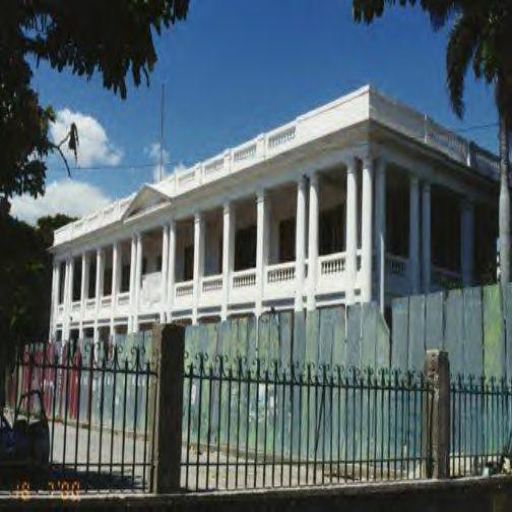

In [11]:
sample[1]

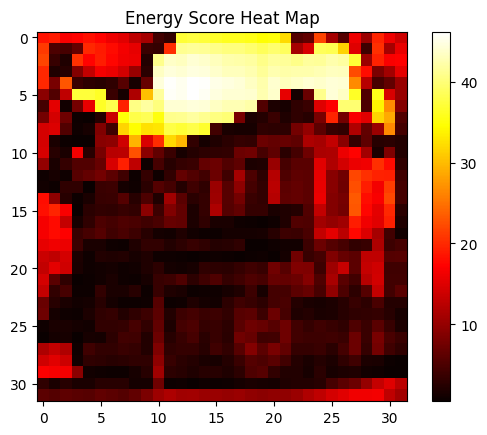

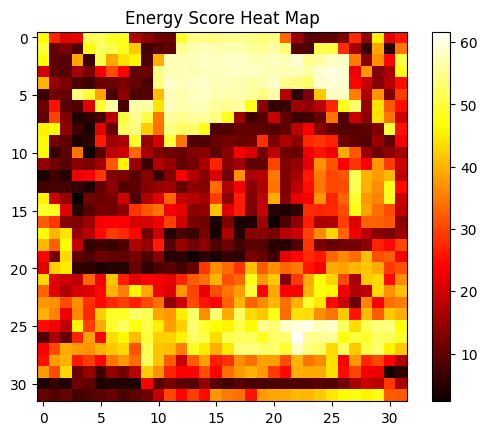

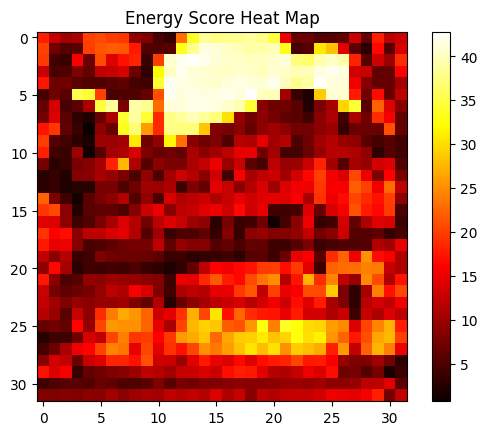

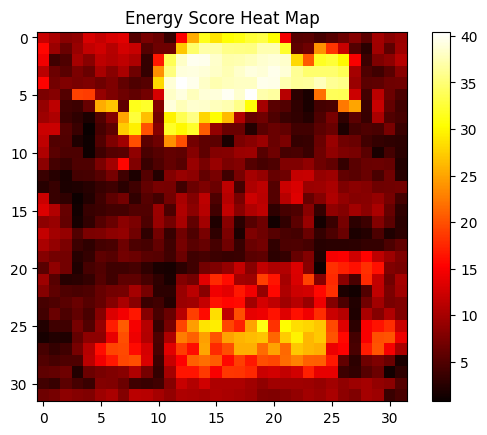

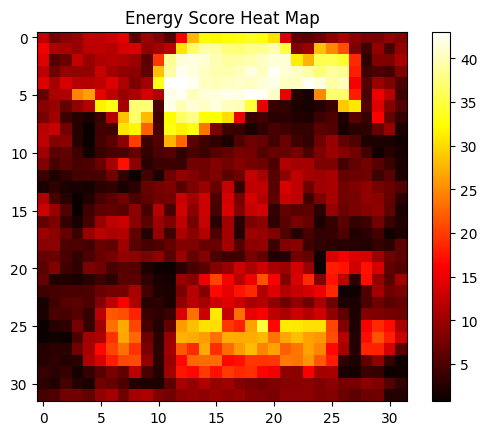

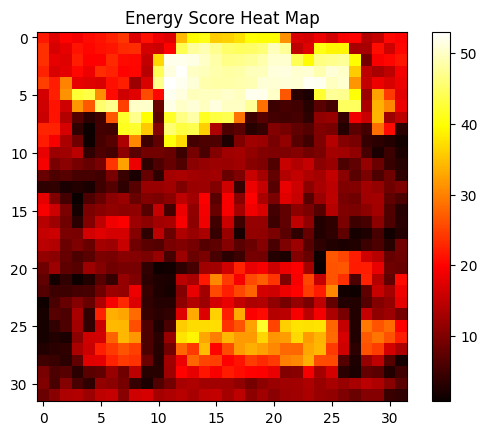

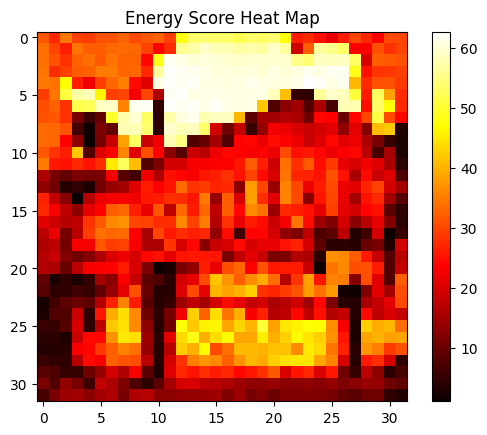

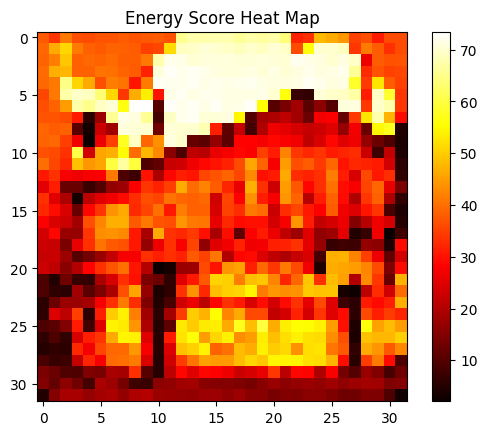

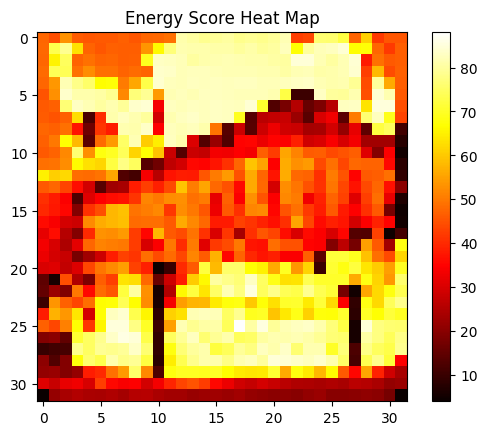

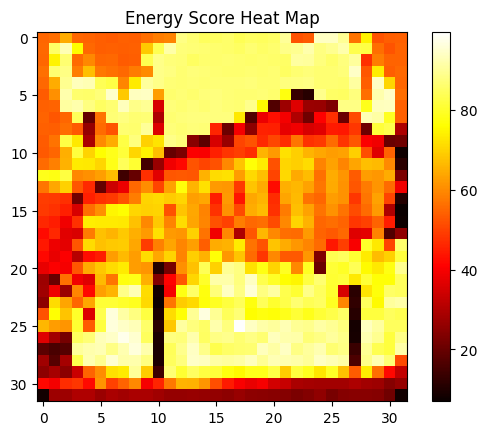

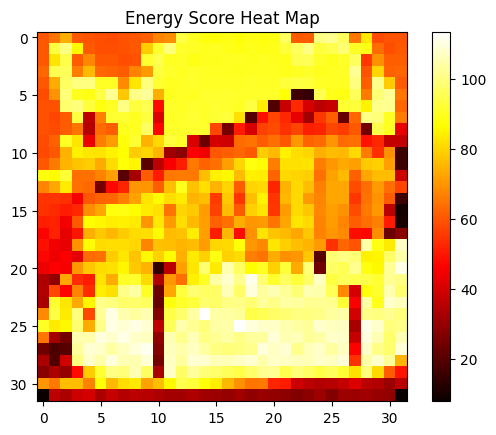

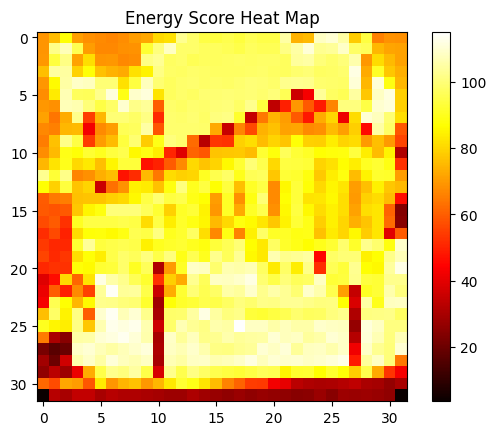

In [12]:
import numpy as np

import matplotlib.pyplot as plt
for hidden_state in all_hidden_states:
   energy_score = cal_energy(hidden_state, margin=0.5)

   # Reshape the energy score to 32x32
   reshaped_energy_score = energy_score.view(32, 32).cpu().detach().numpy()

   # Plot the heat map
   plt.imshow(reshaped_energy_score, cmap='hot', interpolation='nearest')
   plt.colorbar()
   plt.title('Energy Score Heat Map')
   plt.show()

In [13]:
for idx in [0,2,4]:
   
   print(all_hidden_states[idx].shape)

torch.Size([1, 1025, 192])
torch.Size([1, 1025, 192])
torch.Size([1, 1025, 192])


### Integer

- Unsigned integer: range for n-bits: [0, $2^n-1$], For example with 8-bit (torch.uint8): [0, 255]
- Signed integer two's complement representation, the bit in the last position will represent the sign. For example with 8 bit (torch.int8): [-128, 127]
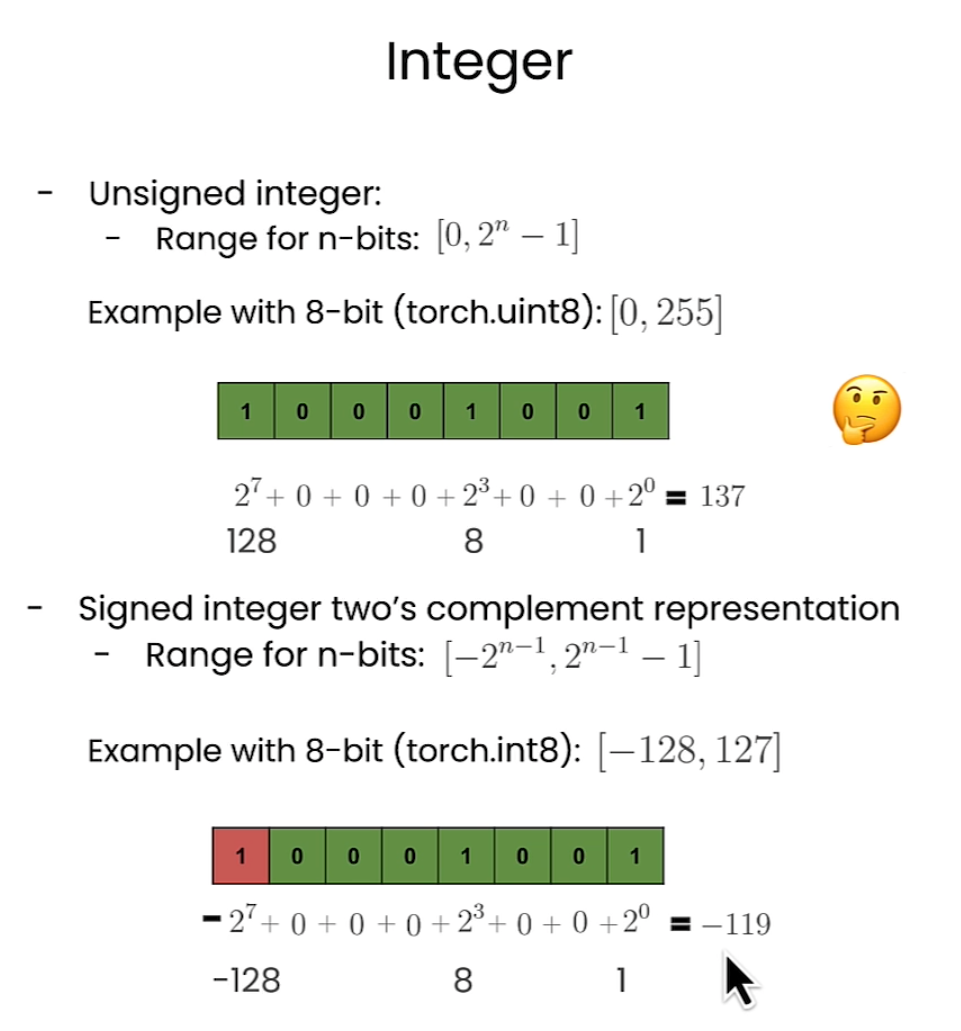


## All integer type in pytorch

In [1]:
import torch

/media/caduser/MyBook/chau/miniconda3/envs/chau/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Information of `8-bit unsigned integer`
print('8 bit unsigned int', torch.iinfo(torch.uint8))
print('8 bit unsigned int', torch.iinfo(torch.int8))
print('16 bit unsigned int', torch.iinfo(torch.int16))
print('32 bit unsigned int', torch.iinfo(torch.int32))
print('64 bit unsigned int', torch.iinfo(torch.int64))

8 bit unsigned int iinfo(min=0, max=255, dtype=uint8)
8 bit unsigned int iinfo(min=-128, max=127, dtype=int8)
16 bit unsigned int iinfo(min=-32768, max=32767, dtype=int16)
32 bit unsigned int iinfo(min=-2.14748e+09, max=2.14748e+09, dtype=int32)
64 bit unsigned int iinfo(min=-9.22337e+18, max=9.22337e+18, dtype=int64)


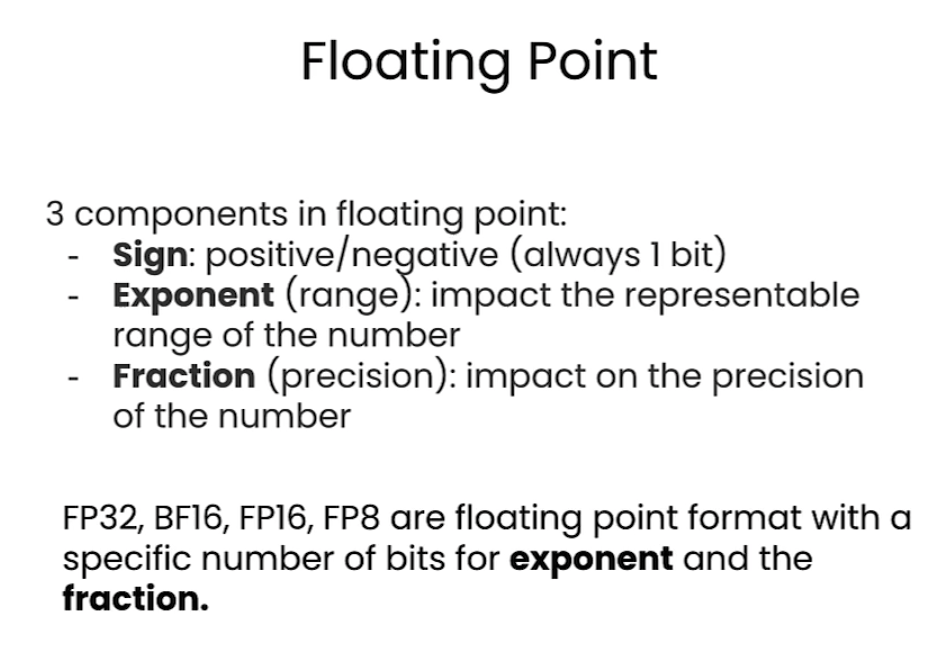

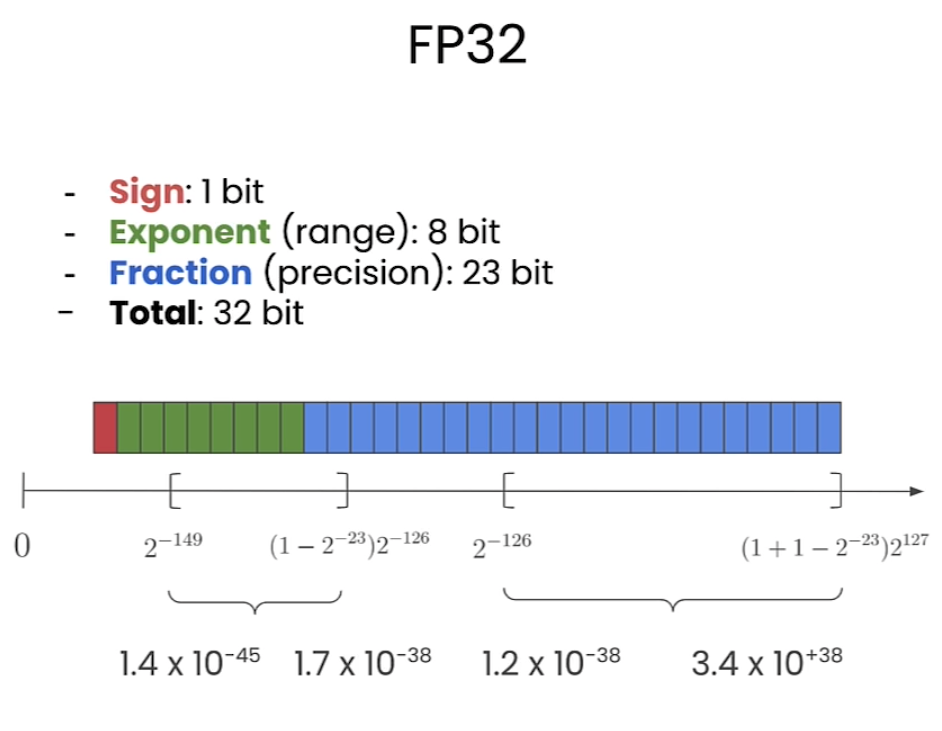

In [7]:
# Information of `8-bit unsigned integer`
print('16 bit floating point', torch.finfo(torch.float16))
print('16 brain floating point', torch.finfo(torch.bfloat16))
print('32 bit floating point', torch.finfo(torch.float32))
print('64 bit floating point', torch.finfo(torch.float64))

16 bit floating point finfo(resolution=0.001, min=-65504, max=65504, eps=0.000976562, smallest_normal=6.10352e-05, tiny=6.10352e-05, dtype=float16)
16 brain floating point finfo(resolution=0.01, min=-3.38953e+38, max=3.38953e+38, eps=0.0078125, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=bfloat16)
32 bit floating point finfo(resolution=1e-06, min=-3.40282e+38, max=3.40282e+38, eps=1.19209e-07, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=float32)
64 bit floating point finfo(resolution=1e-15, min=-1.79769e+308, max=1.79769e+308, eps=2.22045e-16, smallest_normal=2.22507e-308, tiny=2.22507e-308, dtype=float64)


In [15]:
value = 1/3

tensor_b16 = torch.tensor(value, dtype=torch.bfloat16)
print(f"bfp16 tensor: {format(tensor_b16.item(), '.60f')}")
tensor_f16 = torch.tensor(value, dtype=torch.float16)
print(f"fp16 tensor: {format(tensor_f16.item(), '.60f')}")
tensor_f32 = torch.tensor(value, dtype=torch.float32)
print(f"fp32 tensor: {format(tensor_f32.item(), '.60f')}")
tensor_f64 = torch.tensor(value, dtype=torch.float64)
print(f"fp64 tensor: {format(tensor_f64.item(), '.60f')}")

bfp16 tensor: 0.333984375000000000000000000000000000000000000000000000000000
fp16 tensor: 0.333251953125000000000000000000000000000000000000000000000000
fp32 tensor: 0.333333343267440795898437500000000000000000000000000000000000
fp64 tensor: 0.333333333333333314829616256247390992939472198486328125000000


In [ ]:
from transformers import SamModel, SamProcessor 

def print_params(model):
   for name, param in model.named_parameters():
      print(name, param.dtype)

model = SamModel.from_pretrained('facebook/sam-vit-huge')


print_params(model.half())



vision_encoder.pos_embed torch.float16
vision_encoder.patch_embed.projection.weight torch.float16
vision_encoder.patch_embed.projection.bias torch.float16
vision_encoder.layers.0.layer_norm1.weight torch.float16
vision_encoder.layers.0.layer_norm1.bias torch.float16
vision_encoder.layers.0.attn.rel_pos_h torch.float16
vision_encoder.layers.0.attn.rel_pos_w torch.float16
vision_encoder.layers.0.attn.qkv.weight torch.float16
vision_encoder.layers.0.attn.qkv.bias torch.float16
vision_encoder.layers.0.attn.proj.weight torch.float16
vision_encoder.layers.0.attn.proj.bias torch.float16
vision_encoder.layers.0.layer_norm2.weight torch.float16
vision_encoder.layers.0.layer_norm2.bias torch.float16
vision_encoder.layers.0.mlp.lin1.weight torch.float16
vision_encoder.layers.0.mlp.lin1.bias torch.float16
vision_encoder.layers.0.mlp.lin2.weight torch.float16
vision_encoder.layers.0.mlp.lin2.bias torch.float16
vision_encoder.layers.1.layer_norm1.weight torch.float16
vision_encoder.layers.1.layer_no

In [18]:
value32 = torch.tensor(1/3, dtype=torch.float32)
value16 = torch.tensor(1/3, dtype=torch.float16)

value32 - value16

tensor(8.1390e-05)

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
num_params = model.num_parameters()
print(f'number of params {num_params/ 1e+9}B')
fp32_mem_footprint = model.float().get_memory_footprint()
print('footprint of the fp32 model in MBs:', fp32_mem_footprint/1e+6)
fp32_mem_footprint = model.half().get_memory_footprint()
print('footprint of the fp16 model in MBs:', fp32_mem_footprint/1e+6)

number of params 0.641090608B
footprint of the fp32 model in MBs: 2564.363456
footprint of the fp16 model in MBs: 1282.181728


In [35]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

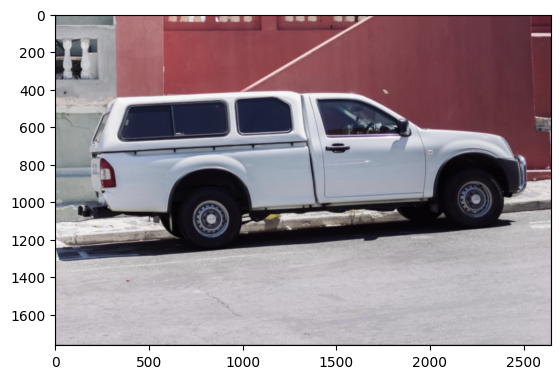

In [51]:
from PIL import Image
import matplotlib.pyplot as plt 
import requests

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

plt.imshow(raw_image)

inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"].half())

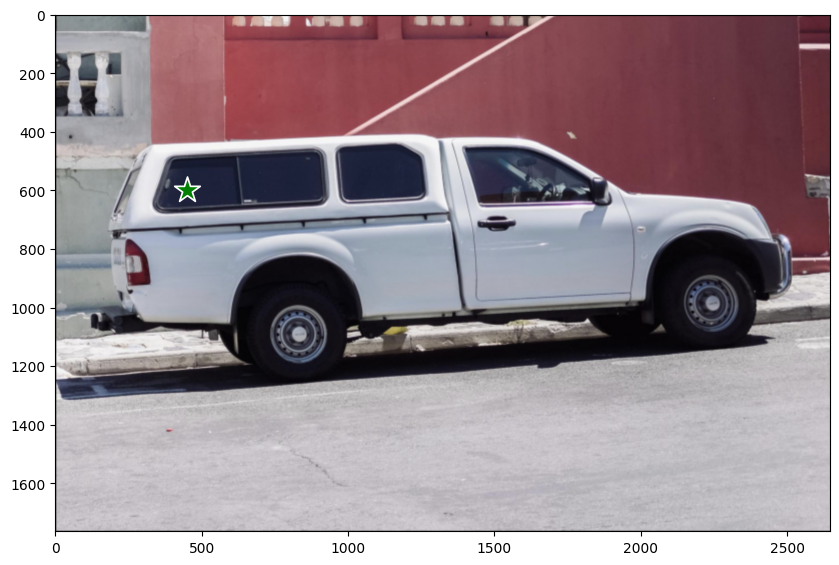

In [56]:
input_points = [[[450, 600]]]
show_points_on_image(raw_image, input_points[0])

In [ ]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.float().cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

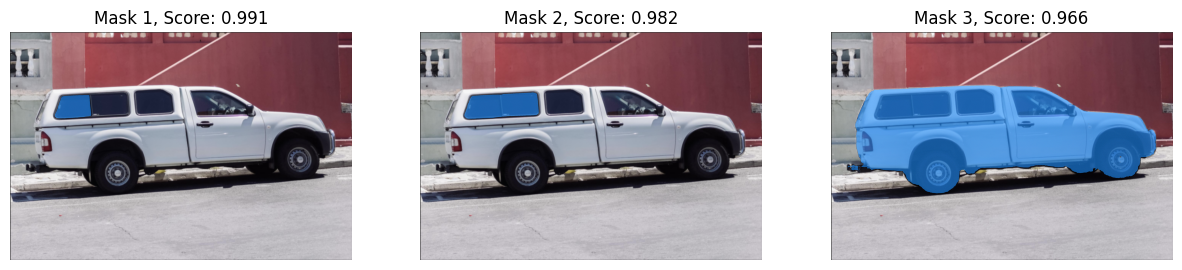

In [ ]:
show_masks_on_image(raw_image, masks[0], scores)

In [61]:
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0): SamVisionLayer(
        (layer_norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (layer_norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELUActivation()
        )
      )
      (1): SamVisionLayer(
        (layer_norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (q

In [7]:
torch.iinfo(torch.int8)

iinfo(min=-128, max=127, dtype=int8)

In [15]:
from quanto import quantize, freeze, quantize_weight
from transformers import SamModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)


quantize(model, weights='qint2')



print(model)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): QConv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-31): 32 x SamVisionLayer(
        (layer_norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): QLinear(in_features=1280, out_features=3840, bias=True)
          (proj): QLinear(in_features=1280, out_features=1280, bias=True)
        )
        (layer_norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): QLinear(in_features=1280, out_features=5120, bias=True)
          (lin2): QLinear(in_features=5120, out_features=1280, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): QConv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLa

In [18]:
freeze(model)

model.vision_encoder.layers[0].attn.qkv.weight.data


QBitsTensor(PackedTensor(tensor([[159, 154, 154,  ...,  89, 153,  26],
        [ 89,  89, 169,  ..., 153, 105, 105],
        [ 41, 109, 169,  ...,  41, 169, 105],
        ...,
        [ 85,  41,  37,  ..., 101, 101, 101],
        [169, 169, 169,  ..., 169, 169, 217],
        [137, 217, 153,  ...,  41, 149, 217]], device='cuda:0',
       dtype=torch.uint8), bits=2, public_dtype=torch.uint8), scale=tensor([[0.0975],
        [0.2627],
        [0.2140],
        ...,
        [0.0620],
        [0.0598],
        [0.0599]], device='cuda:0'), zeropoint=tensor([[2],
        [1],
        [1],
        ...,
        [1],
        [2],
        [2]], device='cuda:0', dtype=torch.int8), dtype=torch.float32)

In [1]:
import torch
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [1]:
q.shape

NameError: name 'q' is not defined